In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

from pathlib import Path
import os.path

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load data
#via : https://www.kaggle.com/datasets/vencerlanz09/pharmaceutical-drugs-and-vitamins-dataset-v2

dataset = 'res/Drug Vision/Data Combined'
img_dir = Path(dataset)

file_paths = list(img_dir.glob(r'**/*.jpg')) + list(img_dir.glob(r'**/*.png'))


labels = list(map(lambda x : os.path.split(os.path.split(x)[0])[1], file_paths))

file_paths = pd.Series(file_paths, name = 'file_path').astype('str')
labels = pd.Series(labels, name = 'label').astype('str')

img_df = pd.concat([file_paths, labels], axis=1)

In [3]:
img_df

,file_path,label
0,res\Drug Vision\Data Combined\Alaxan\00000000.jpg,Alaxan
1,res\Drug Vision\Data Combined\Alaxan\00000001.jpg,Alaxan
2,res\Drug Vision\Data Combined\Alaxan\00000002.jpg,Alaxan
3,res\Drug Vision\Data Combined\Alaxan\00000003.jpg,Alaxan
4,res\Drug Vision\Data Combined\Alaxan\00000004.jpg,Alaxan
...,...,...
9995,res\Drug Vision\Data Combined\Neozep\00000995.jpg,Neozep
9996,res\Drug Vision\Data Combined\Neozep\00000996.jpg,Neozep
9997,res\Drug Vision\Data Combined\Neozep\00000997.jpg,Neozep
9998,res\Drug Vision\Data Combined\Neozep\00000998.jpg,Neozep


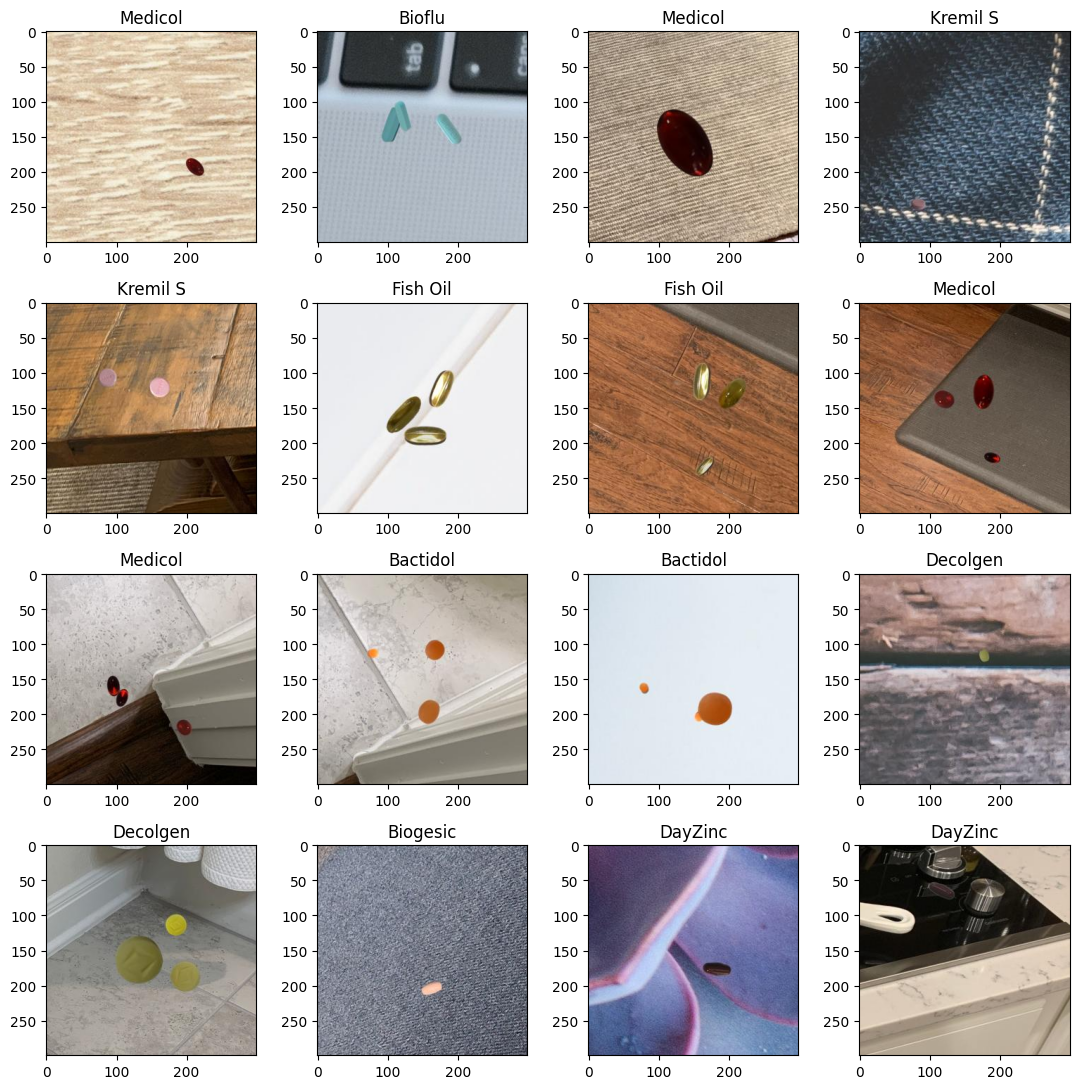

In [4]:
# data visualization
random_idx = np.random.randint(0,len(img_df), 16)
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(11,11))

for i, ax in enumerate(ax.flat):
   ax.imshow(plt.imread(img_df.file_path[random_idx[i]])) 
   ax.set_title(img_df.label[random_idx[i]])

plt.tight_layout()   
   

In [5]:
# data preprocessing : train - test split, data augmentation, resize, rescaling

# train - test split

train_df, test_df = train_test_split(img_df, test_size=0.2, shuffle=True, random_state=42)

print(len(train_df), len(test_df))

8000 2000


In [6]:
# data augmentation
train_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
                                     ,validation_split=0.2)

test_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)


In [7]:
x_col = 'file_path' # independent
y_col = 'label' # dependent - target variable
img_size = 224 # target size : mobilenet input size
color_mode = 'rgb'
class_mode = 'categorical'
batch_size = 128
seed = 42

In [8]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col = x_col, 
    y_col = y_col, 
    target_size = (img_size,img_size), 
    color_mode = color_mode,
    class_mode = class_mode,
    batch_size = batch_size,
    subset = 'training',
    shuffle=True,
    seed = seed
) 

Found 6400 validated image filenames belonging to 10 classes.


In [9]:
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col = x_col, 
    y_col = y_col, 
    target_size = (img_size,img_size), 
    color_mode = color_mode,
    class_mode = class_mode,
    batch_size = batch_size,
    subset = 'validation',
    shuffle=True,
    seed = seed
) 

Found 1600 validated image filenames belonging to 10 classes.


In [10]:
test_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col = x_col, 
    y_col = y_col, 
    target_size = (img_size,img_size), 
    color_mode = color_mode,
    class_mode = class_mode,
    batch_size = batch_size,
    subset = 'validation',
    shuffle = False,
) 

Found 1600 validated image filenames belonging to 10 classes.


In [11]:
# resize, rescaling
resize_and_rescale = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.Rescaling(1./255),
        layers.experimental.preprocessing.Resizing(img_size, img_size),
    ]
)

In [12]:
# transfer learning model (MobileNetV2), training

default_model = tf.keras.applications.MobileNetV2(
    input_shape=(img_size, img_size, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

default_model.trainable = False


In [13]:
# model summary
default_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [14]:
# create checkpoint callback
checkpoint_path = 'output/pharmaceutical_drugs_and_vitamins_classification_model_checkpoint' # save to output folder.
check_point_callback = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True,
)

In [15]:
# early stop
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience = 5, # if loss stable since 5 epochs 
    restore_best_weights=True
)

In [16]:
# create model
inputs = default_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(default_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(10, activation='softmax')(x)

model = Model(inputs = inputs, outputs = outputs)



In [17]:
# train model
model.compile(optimizer=Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=15,
    callbacks=[early_stopping, check_point_callback])

Epoch 1/15
50/50 [==============================] - 18s 301ms/step - loss: 2.1287 - accuracy: 0.2527 - val_loss: 1.6604 - val_accuracy: 0.5519
Epoch 2/15
50/50 [==============================] - 14s 272ms/step - loss: 1.4946 - accuracy: 0.5245 - val_loss: 1.1050 - val_accuracy: 0.6888
Epoch 3/15
50/50 [==============================] - 14s 268ms/step - loss: 1.1192 - accuracy: 0.6361 - val_loss: 0.8478 - val_accuracy: 0.7556
Epoch 4/15
50/50 [==============================] - 14s 269ms/step - loss: 0.9014 - accuracy: 0.7034 - val_loss: 0.7211 - val_accuracy: 0.7856
Epoch 5/15
50/50 [==============================] - 14s 272ms/step - loss: 0.7861 - accuracy: 0.7348 - val_loss: 0.6408 - val_accuracy: 0.8006
Epoch 6/15
50/50 [==============================] - 14s 276ms/step - loss: 0.6922 - accuracy: 0.7713 - val_loss: 0.5874 - val_accuracy: 0.8181
Epoch 7/15
50/50 [==============================] - 14s 279ms/step - loss: 0.6280 - accuracy: 0.7953 - val_loss: 0.5480 - val_accuracy: 0.8231